In [1]:
import numpy as np
from copy import deepcopy

from plotstyle import init_style, COLORS
init_style()

from qspectro2d.config import SCRIPTS_DIR

from qspectro2d.spectroscopy import compute_2d_fft_wavenumber
from qspectro2d.visualization import plot_example_evo, plot_2d_el_field
from qspectro2d.spectroscopy.one_d_field import compute_polarization_over_window, slice_states_to_window, compute_evolution, sim_with_only_pulses, phase_cycle_component
from qspectro2d.utils.units_and_rwa import from_rotating_frame_list
from qspectro2d.utils.units_and_rwa import from_rotating_frame_list, get_expect_vals_with_RWA

from qspectro2d.config import create_base_sim_oqs
from qspectro2d.utils.data_io import save_simulation_data


In [2]:
config_path = SCRIPTS_DIR / "config.yaml"
# Build base simulation (applies CLI overrides inside)
sim_oqs, time_cut = create_base_sim_oqs(config_path=str(config_path) if config_path else None)

🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)


<string>:15: UserWarning: rwa_sl forced True for Paper_eqs solver.


In [3]:
avg_E_sigs = [np.zeros((len(sim_oqs.t_det), ), dtype=complex)]
metadata = {
    "n_batches": 1,
    "signal_types": sim_oqs.simulation_config.signal_types,
}
abs_data_path = save_simulation_data(
    sim_oqs, metadata, avg_E_sigs, t_det=sim_oqs.t_det
)
abs_data_path
str(abs_data_path)

2025-09-19 12:05:16 | INFO | qspectro2d.utils.data_io:124 | Info saved: C:\Users\leopo\.vscode\master_thesis\data\1d_spectroscopy\N1\f16000cm_mu1.0\Paper_eqs\RWA\t_dm60.0_t_wait_1.0_dt_0.1\t_coh_30.0_info.pkl


'C:\\Users\\leopo\\.vscode\\master_thesis\\data\\1d_spectroscopy\\N1\\f16000cm_mu1.0\\Paper_eqs\\RWA\\t_dm60.0_t_wait_1.0_dt_0.1\\t_coh_30.0_data.npz'

pulse_delays: [np.float64(30.0), np.float64(1.0)]
Updated pulse_delays: [np.float64(1.493), np.float64(1.0000000000000002)]
LaserPulseSequence Summary
--------------------------------------------------------------------------------
Pulse  1: t =   1.49 fs | E₀ = 1.000e-02 | FWHM =  6.0 fs | ω = 16000.00 cm^-1 | ϕ =  0.000 rad | type = cos2   


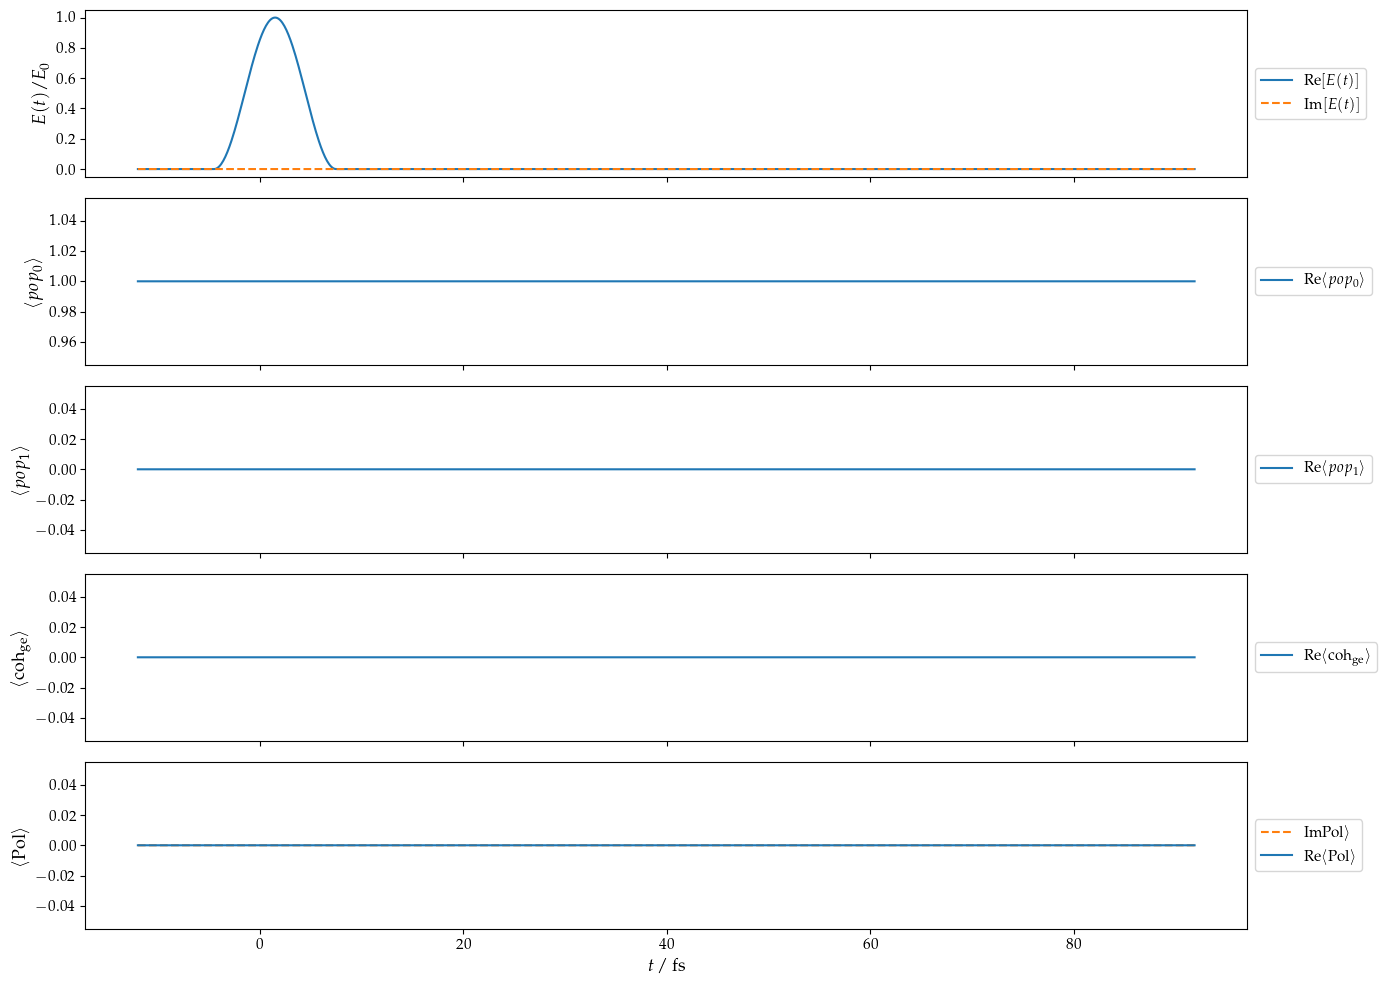

In [4]:
pulse_delays = sim_oqs.laser.pulse_delays
print("pulse_delays:", pulse_delays)
# TODO bigger than this will cause NO evolution!! Why?
pulse_delays[0] = 1.493  # Set first delay to 1.45 for single-pulse simulation
sim_oqs.laser.pulse_delays = pulse_delays
print("Updated pulse_delays:", sim_oqs.laser.pulse_delays)
sim_i = sim_with_only_pulses(sim_oqs, [1])
print(sim_i.laser)
res = compute_evolution(sim_i)
det_states = res.states


times = res.times
rwa_sl = sim_i.simulation_config.rwa_sl
if rwa_sl:
    # States are stored in the rotating frame; convert back to lab for polarization
    det_states = from_rotating_frame_list(
        det_states, times, sim_i.system.n_atoms, sim_i.laser.carrier_freq_fs
    )
expectation_values = get_expect_vals_with_RWA(det_states, 
                                              times - times[0], 
                                              sim_i.system.n_atoms,
                                              sim_i.observable_ops, 
                                              sim_i.laser.carrier_freq_fs,
                                              rwa_sl=rwa_sl,
                                              dipole_op=sim_i.system.dipole_op)

fig_evo = plot_example_evo(times, expectation_values, sim_i.laser, rwa_sl=rwa_sl, observable_strs=sim_i.observable_strs)
display(fig_evo)

# Workflow: `parallel_compute_1d_e_comps`

Super-short stepped visualization added below:
1. Inspect and plot laser pulses (envelope, RWA field, full field).
2. Run several evolutions with different active pulse subsets / modified parameters.
3. Plot expectation values + polarization for multiple detection sub-windows.
4. Build raw phase grid `P_{phi1,phi2}(t)` and extract a phase-cycled component.
5. (Mini 2D) Sweep a few coherence delays `t_coh` to assemble a tiny 2D block and phase-cycle each slice.

Each subsequent cell implements one step.


In [5]:
# Helper functions: polarization + phase-cycling pieces
def build_phase_grid(sim, phases):
    P_grid = []
    t_actual = None
    for phi1 in phases:
        row = []
        for phi2 in phases:
            sim_w = deepcopy(sim)
            sim_w.laser.pulse_phases = [phi1, phi2]
            t_actual, P_phi = compute_polarization_over_window(sim_w, sim_w.t_det_actual)
            row.append(P_phi)
        P_grid.append(row)
    return t_actual, np.array(P_grid)  # shape (n,n,t)
print('Helpers ready.')

Helpers ready.


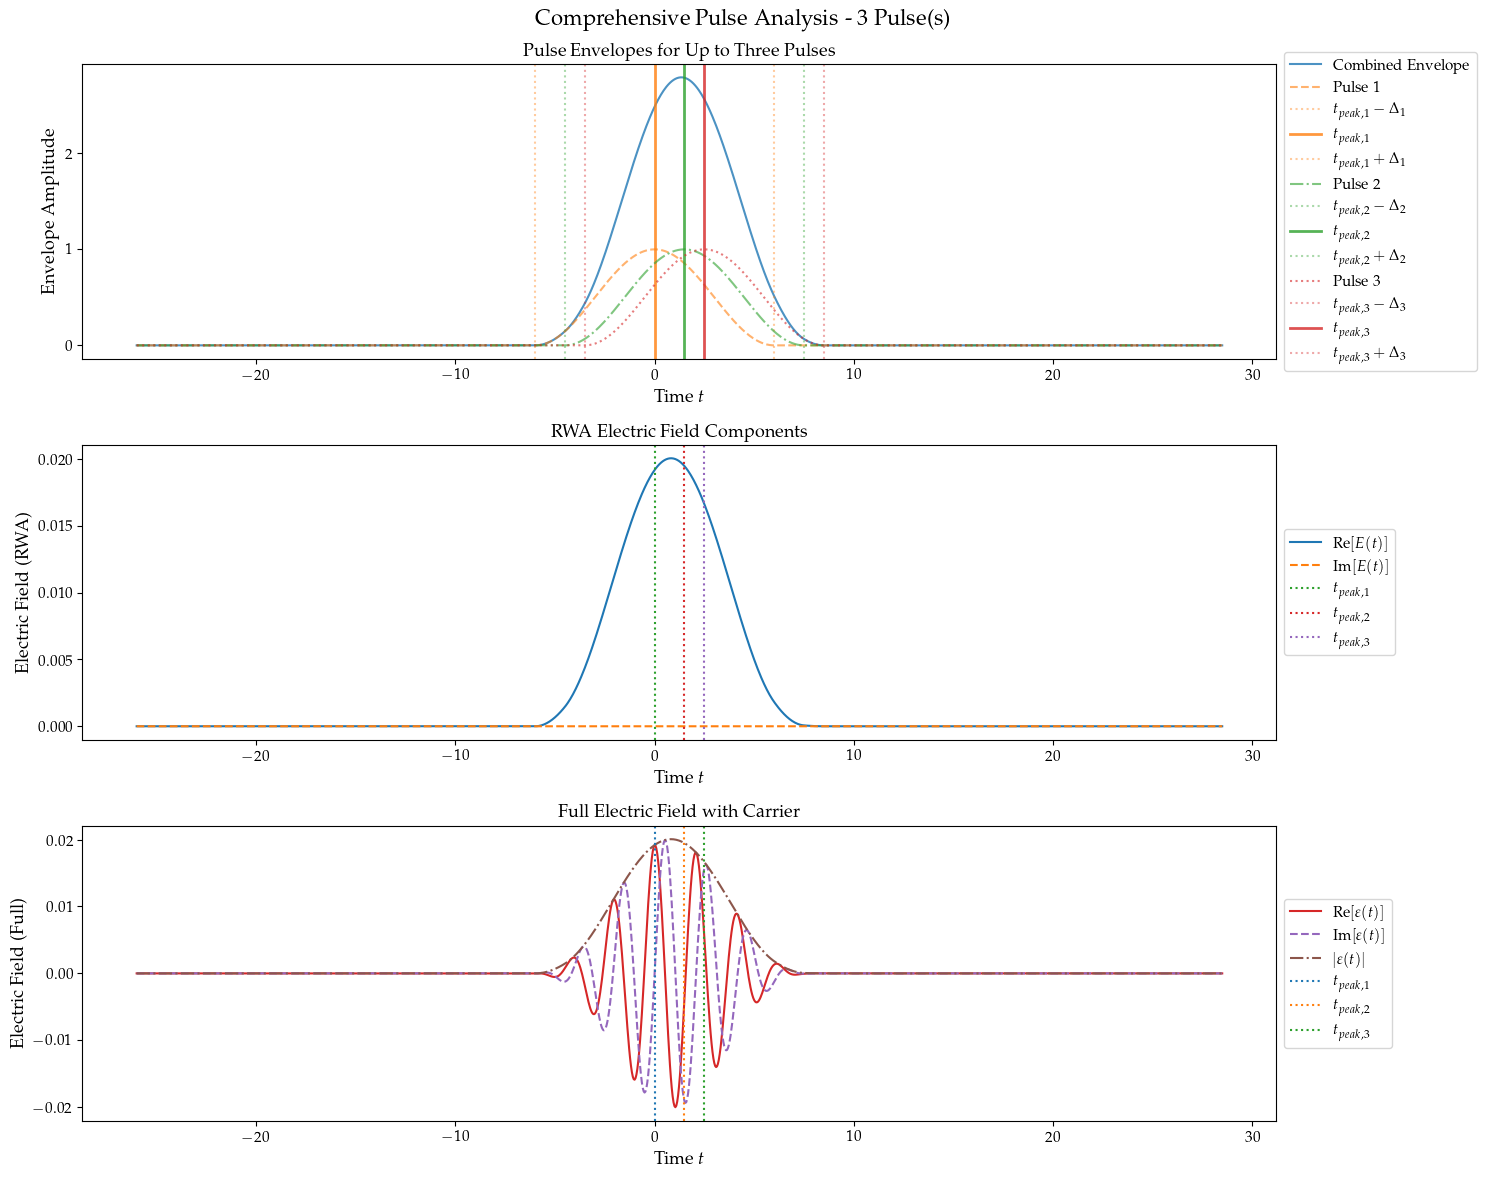

In [6]:
# 1. Laser pulses visualization
from qspectro2d.visualization.plotting import plot_all_pulse_components

pulse_times = np.linspace(sim_oqs.laser.pulses[0].active_time_range[0]-20.0,
                          sim_oqs.laser.pulses[-1].active_time_range[1]+20.0, 1200)
fig_pulses = plot_all_pulse_components(pulse_times, sim_oqs.laser)
fig_pulses

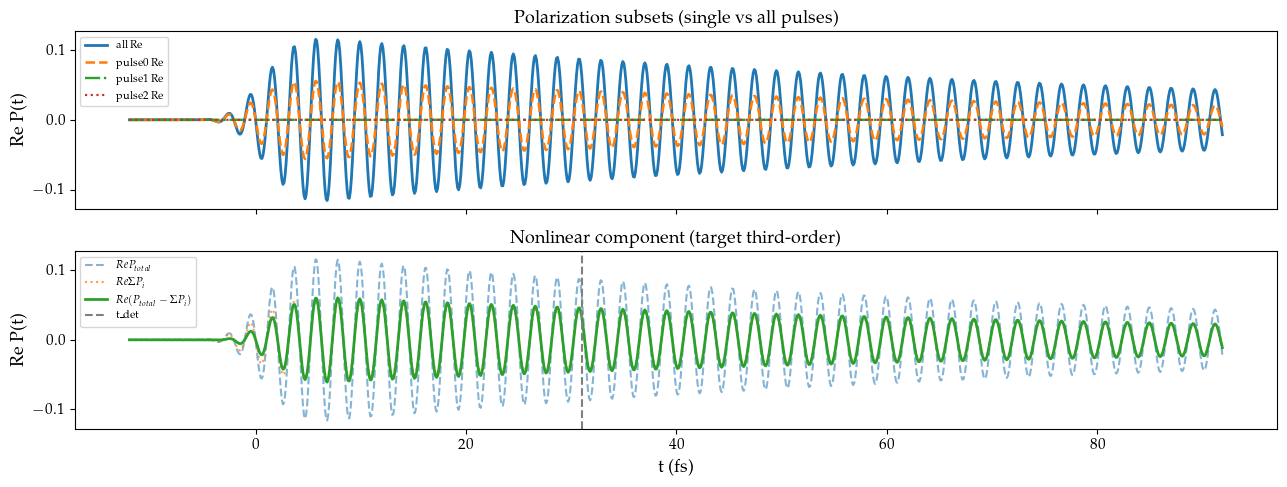

In [7]:
# 2. Evolution subsets: all pulses vs single pulse vs modified amplitude
subset_specs = {
    'all': list(range(len(sim_oqs.laser.pulses))),
}
# Add individual pulses
for i in range(len(sim_oqs.laser.pulses)):
    subset_specs[f'pulse{i}'] = [i]

pol_datas = {}
base_window = sim_oqs.times_local  # detection / plotting window (assumed uniform grid)

for label, idxs in subset_specs.items():
    sim_sub = sim_with_only_pulses(sim_oqs, idxs) if label != 'all' else sim_oqs
    t_actual, P = compute_polarization_over_window(sim_sub, base_window)
    pol_datas[label] = P

# Build nonlinear component: P_total - Σ_i P_i
P_total = pol_datas['all']
linear_sum = np.zeros_like(P_total, dtype=complex)
for i in range(len(sim_oqs.laser.pulses)):
    linear_sum += pol_datas[f'pulse{i}']
pol_nonlinear = P_total - linear_sum  # store for later reuse if needed

# Plotting: two subplots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(13,5), sharex=True)
ax1, ax2 = axes

# Subplot 1: original subset comparison (real part)
for idx, (k, v) in enumerate(pol_datas.items()):
    ax1.plot(t_actual, np.real(v), color=COLORS[idx % len(COLORS)], linewidth=2-0.15*idx, label=f'{k} Re')
ax1.set_ylabel('Re P(t)')
ax1.set_title('Polarization subsets (single vs all pulses)')
ax1.legend(loc='best', fontsize=8)

# Subplot 2: nonlinear component extraction
ax2.plot(t_actual, np.real(P_total), label='$Re P_{total}$', linestyle='--', color=COLORS[0], alpha=0.55)
ax2.plot(t_actual, np.real(linear_sum), label='$Re \Sigma P_i$', linestyle=':', color=COLORS[1], alpha=0.75)
ax2.plot(t_actual, np.real(pol_nonlinear), label='$Re (P_{total} - \Sigma P_i)$', color=COLORS[2], linewidth=2.0)
# make a vertical line at t_det_actual[0]
ax2.axvline(x=sim_oqs.t_det_actual[0], color='gray', linestyle='--', label='t_det')
ax2.set_ylabel('Re P(t)')
ax2.set_xlabel('t (fs)')
ax2.set_title('Nonlinear component (target third-order)')
ax2.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

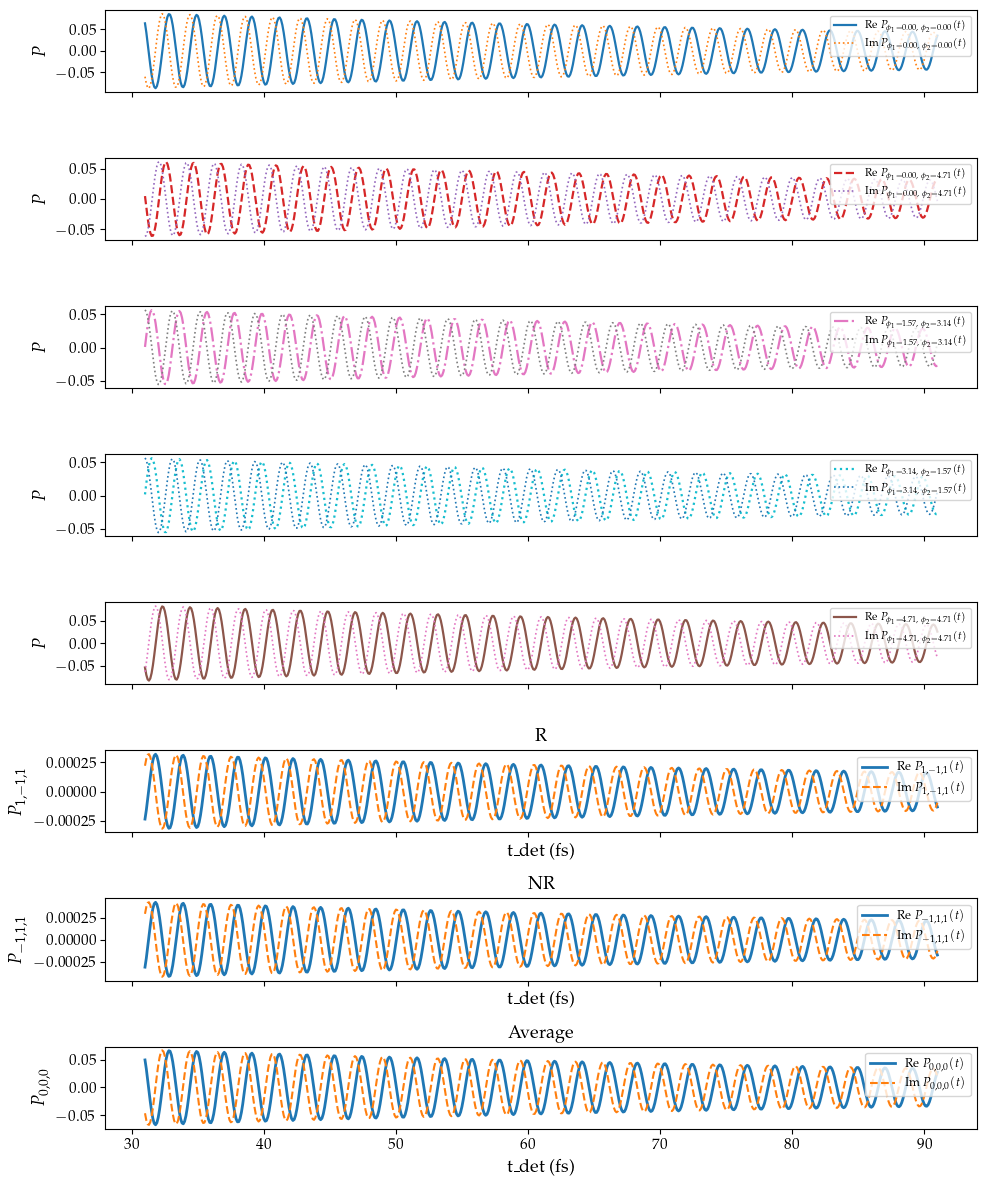

In [8]:
# 4. Phase grid raw vs extracted component (expanded visualization)
from qspectro2d.config.default_simulation_params import PHASE_CYCLING_PHASES, DETECTION_PHASE
phases = PHASE_CYCLING_PHASES[:4]  # small subset for speed

# Build raw grid (n_phi, n_phi, n_t)
t_actual, P_grid = build_phase_grid(sim_oqs, phases)
comp = phase_cycle_component(phases, P_grid, lmn=(1,-1,1), phi_det=DETECTION_PHASE)

# Select several (phi1, phi2) pairs to display (indices into phases)
# Always include (0,0) and (last,last); add a few interior/off-diagonal examples.
max_idx = len(phases) - 1
pairs_to_show = [(0,0)]
if max_idx >= 1:
    pairs_to_show.append((0, max_idx))  # corner
if max_idx >= 2:
    pairs_to_show.append((1, 2))        # interior
if max_idx >= 3:
    pairs_to_show.append((2, 1))        # off-diagonal reversed
pairs_to_show.append((max_idx, max_idx))

# Prepare figure: raw traces + component at bottom
n_raw = len(pairs_to_show)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(n_raw + 3, 1, figsize=(10, 2.0*(n_raw+1)), sharex=True)

# Color / style cycling
from itertools import cycle
line_styles = cycle(['solid','dashed','dashdot','dotted'])

for ax, (i,j) in zip(axes[:-3], pairs_to_show):
    trace = P_grid[i,j]
    ls = next(line_styles)
    color_idx = (i * len(phases) + j) % len(COLORS)
    ax.plot(t_actual, np.real(trace), color=COLORS[color_idx], linestyle=ls, linewidth=1.6,
            label=fr"Re $P_{{\phi_1={phases[i]:.2f},\;\phi_2={phases[j]:.2f}}}(t)$")
    ax.plot(t_actual, np.imag(trace), color=COLORS[(color_idx+1)%len(COLORS)], linestyle=':', linewidth=1.2,
            label=fr"Im $P_{{\phi_1={phases[i]:.2f},\;\phi_2={phases[j]:.2f}}}(t)$")
    ax.set_ylabel(r"$P$")
    ax.legend(fontsize=8, loc='upper right')

# Component subplot
axc = axes[-3]
axc.plot(t_actual, np.real(comp), color=COLORS[0], linewidth=2.0, label=r"Re $P_{1,-1,1}(t)$")
axc.plot(t_actual, np.imag(comp), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im $P_{1,-1,1}(t)$")
axc.set_ylabel(r"$P_{1,-1,1}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('R')
axc.legend(fontsize=9, loc='upper right')

# Extra: show another component (e.g. (-1,1,1)) for comparison
comp2 = phase_cycle_component(phases, P_grid, lmn=(-1,1,1), phi_det=DETECTION_PHASE)
axc = axes[-2]
axc.plot(t_actual, np.real(comp2), color=COLORS[0], linewidth=2.0, label=r"Re $P_{-1,1,1}(t)$")
axc.plot(t_actual, np.imag(comp2), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im $P_{-1,1,1}(t)$")
axc.set_ylabel(r"$P_{-1,1,1}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('NR')
axc.legend(fontsize=9, loc='upper right')

# Extra: show another component (e.g. (0, 0, 0)) for comparison
comp3 = phase_cycle_component(phases, P_grid, lmn=(0, 0, 0), phi_det=DETECTION_PHASE)
axc = axes[-1]
axc.plot(t_actual, np.real(comp3), color=COLORS[0], linewidth=2.0, label=r"Re $P_{0,0,0}(t)$")
axc.plot(t_actual, np.imag(comp3), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im $P_{0,0,0}(t)$")
axc.set_ylabel(r"$P_{0,0,0}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('Average')
axc.legend(fontsize=9, loc='upper right')
plt.tight_layout()
plt.show()

In [16]:
# 5. Mini 2D demo: scan a few coherence pulse_delays (t_coh values) and phase-cycle each 1D slice
# NOTE: This is a lightweight illustrative sweep, not a full 2D simulation pipeline.
t_det = sim_oqs.t_det
half_time = 0.1 * t_det[-1]              # half of the last detection time
mask = t_det <= half_time                # boolean mask
mini_t_coh = t_det[mask][::2]           # apply mask, then take every 10th

components_2d_R = []
components_2d_NR = []
pulse_times_matrix = []  # store resulting peak times for diagnostics

for tcoh in mini_t_coh:
    sim_c = deepcopy(sim_oqs)
    # Adjust ONLY the first inter-pulse delay using new `pulse_delays` property.
    ds = sim_c.laser.pulse_delays  # list of length n_pulses-1
    if len(ds) == 0:
        raise RuntimeError("Need at least 2 pulses for a coherence delay sweep.")
    ds[0] = tcoh  # set coherence delay
    sim_c.laser.pulse_delays = ds  # applies via setter -> pulse_delays setter
    pulse_times_matrix.append(sim_c.laser.pulse_peak_times)

    # Recompute polarization phase grid for this t_coh
    t_actual2d, P_grid2d = build_phase_grid(sim_c, phases)
    comp2d_R = phase_cycle_component(phases, P_grid2d, lmn=(-1,1, 1), phi_det=DETECTION_PHASE)
    components_2d_R.append(comp2d_R)
    comp2d_NR = phase_cycle_component(phases, P_grid2d, lmn=(1,-1,1), phi_det=DETECTION_PHASE)
    components_2d_NR.append(comp2d_NR)

# Diagnostics: show first few rows of resulting pulse peak times
print('Pulse peak times per t_coh (rows):')
print(pulse_times_matrix)

components_2d_R = np.array(components_2d_R)  # shape (n_t_coh, n_t_det)
components_2d_NR = np.array(components_2d_NR)  # shape (n_t_coh, n_t_det)
pulse_times_matrix = np.array(pulse_times_matrix)

Pulse peak times per t_coh (rows):
[[np.float64(0.0), np.float64(0.0), np.float64(1.0000000000000002)], [np.float64(0.0), np.float64(0.2), np.float64(1.2000000000000002)], [np.float64(0.0), np.float64(0.4), np.float64(1.4000000000000004)], [np.float64(0.0), np.float64(0.6000000000000001), np.float64(1.6000000000000003)], [np.float64(0.0), np.float64(0.8), np.float64(1.8000000000000003)], [np.float64(0.0), np.float64(1.0), np.float64(2.0)], [np.float64(0.0), np.float64(1.2000000000000002), np.float64(2.2)], [np.float64(0.0), np.float64(1.4000000000000001), np.float64(2.4000000000000004)], [np.float64(0.0), np.float64(1.6), np.float64(2.6000000000000005)], [np.float64(0.0), np.float64(1.8), np.float64(2.8000000000000003)], [np.float64(0.0), np.float64(2.0), np.float64(3.0)], [np.float64(0.0), np.float64(2.2), np.float64(3.2)], [np.float64(0.0), np.float64(2.4000000000000004), np.float64(3.4000000000000004)], [np.float64(0.0), np.float64(2.6), np.float64(3.6000000000000005)], [np.float64(

Text(0.5, 1.0, 'Absolute Value of 2D Field in Time Domain')

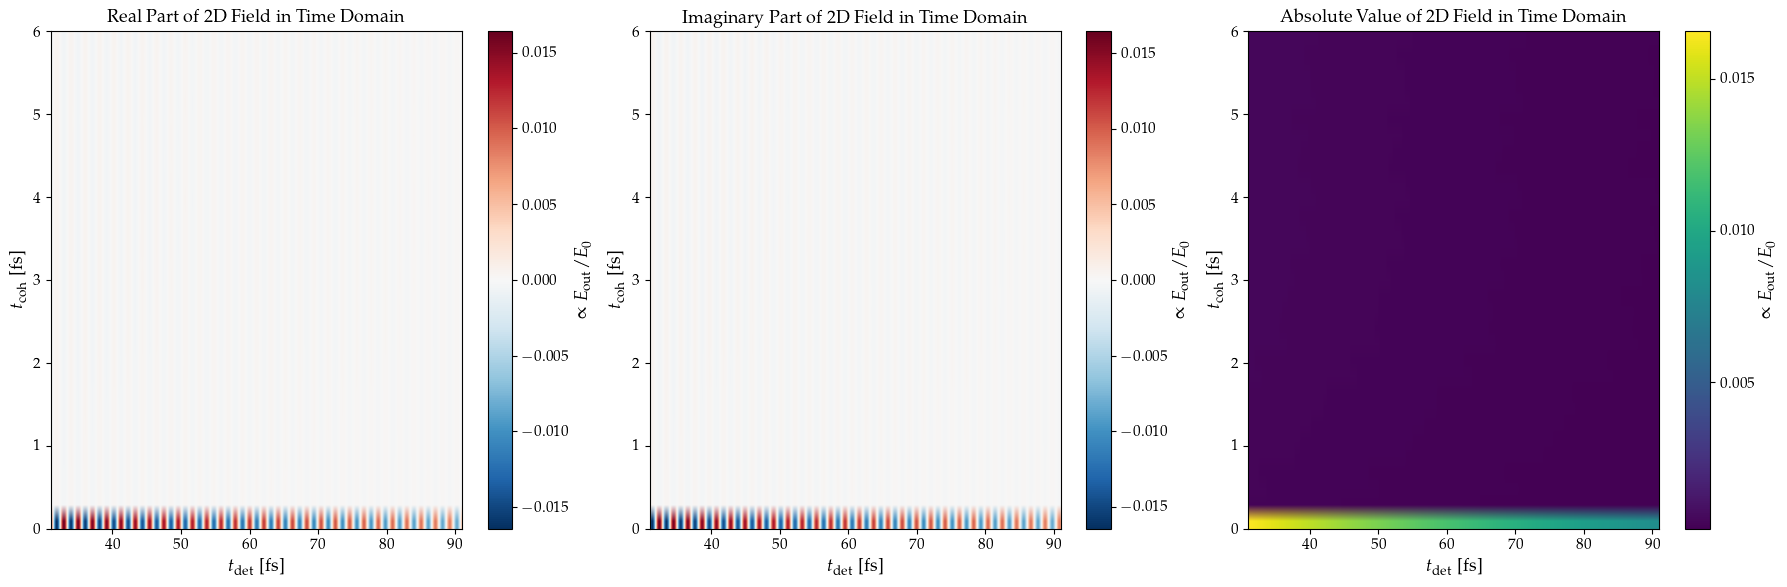

In [17]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_2d_el_field(
    ax=axes[0],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="real",
    normalize=False,
)
axes[0].set_title(r"Real Part of 2D Field in Time Domain")

# Plot imaginary component
plot_2d_el_field(
    ax=axes[1],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="img",
    normalize=False,
)
axes[1].set_title(r"Imaginary Part of 2D Field in Time Domain")

# Plot absolute component
plot_2d_el_field(
    ax=axes[2],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="abs",
    normalize=False,
)
axes[2].set_title(r"Absolute Value of 2D Field in Time Domain")

Text(0.5, 1.0, 'Absolute Value of 2D Field in Time Domain')

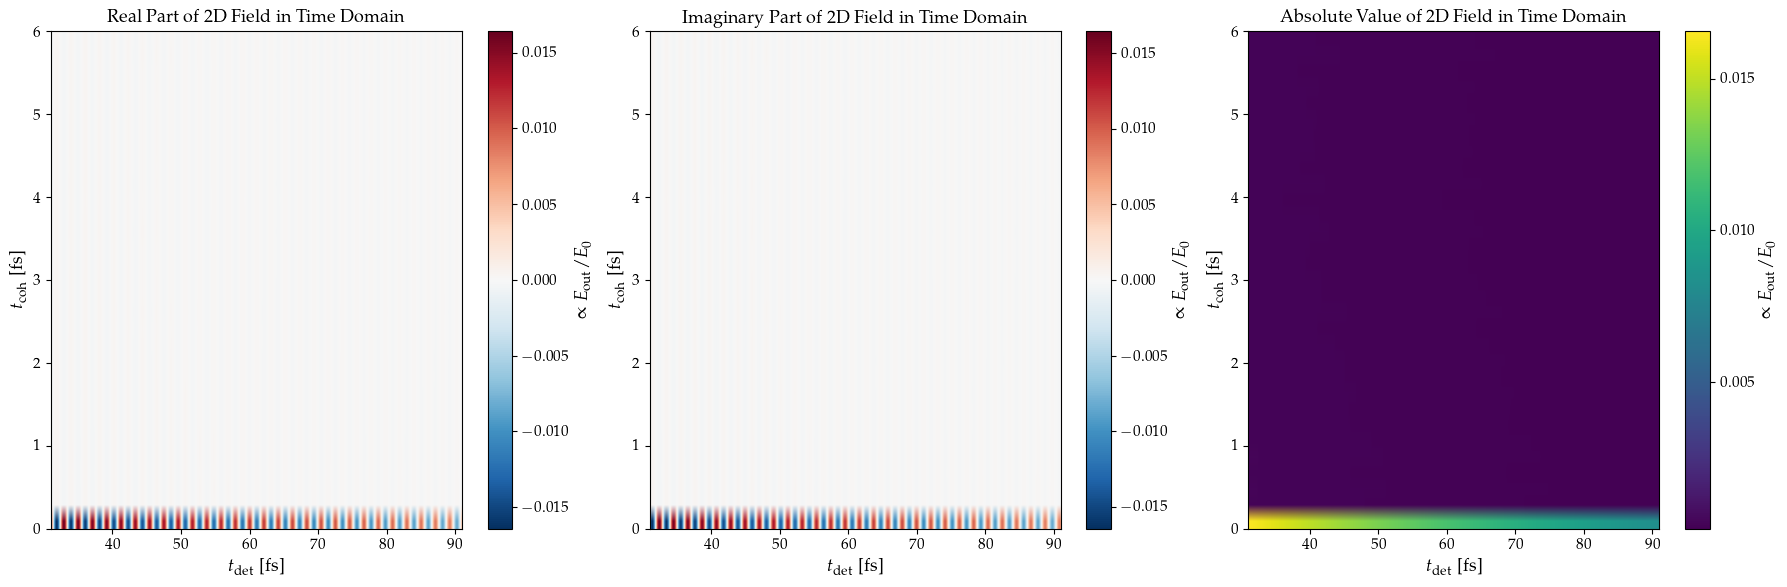

In [18]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_2d_el_field(
    ax=axes[0],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_NR,
    domain="time",
    component="real",
    normalize=False,
)
axes[0].set_title(r"Real Part of 2D Field in Time Domain")

# Plot imaginary component
plot_2d_el_field(
    ax=axes[1],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_NR,
    domain="time",
    component="img",
    normalize=False,
)
axes[1].set_title(r"Imaginary Part of 2D Field in Time Domain")

# Plot absolute component
plot_2d_el_field(
    ax=axes[2],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_NR,
    domain="time",
    component="abs",
    normalize=False,
)
axes[2].set_title(r"Absolute Value of 2D Field in Time Domain")

## 6. Inhomogeneous broadening (1D)

> We emulate an inhomogeneous ensemble by sampling Gaussian-distributed detunings (in cm$^{-1}$),
> phase-shifting the base polarization $P(t)$ as $P_\Delta(t) = P(t)\,e^{-i\,\Delta\omega\,(t-t_0)}$, then averaging.

- Base trace: previously computed `P_all` on the detection axis `det_time_axis`.
- Detunings: $\Delta\tilde\nu \sim \mathcal{N}(0, \sigma_{\text{inh}})$ (cm$^{-1}$) converted to angular frequency (rad/fs).
- Plots: a handful of single realizations (Re only) and the ensemble average vs the base trace.

In [ ]:
# Inhomogeneous broadening: Gaussian detuning ensemble on 1D polarization
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# Preconditions: we use previously computed detection axis and base polarization
t_det = det_time_axis if 'det_time_axis' in locals() else t_actual
P_base = P_all if 'P_all' in locals() else (pol_datas['all'] if 'pol_datas' in locals() else None)
if P_base is None:
    raise RuntimeError("Base polarization P_all not available. Run earlier cells first.")

# Convert cm^-1 to angular frequency in rad/fs
# 1 cm^-1 = 2*pi*c*100 rad/s, with c ≈ 2.99792458e10 cm/s -> rad/s
# Convert to rad/fs by multiplying by 1e-15
c_cm_per_s = 2.99792458e10
cm1_to_radfs = 2*np.pi*c_cm_per_s*1e-15

# Parameters for inhomogeneous broadening
sigma_cm1 = 100.0   # standard deviation in cm^-1 (adjust as desired)
n_real     = 16      # number of ensemble realizations
t0         = t_det[0]  # reference time for phase; you can also use np.min(t_det)

# Sample detunings and build ensemble
rng = np.random.default_rng(42)
deltas_cm1 = rng.normal(loc=0.0, scale=sigma_cm1, size=n_real)
deltas_radfs = deltas_cm1 * cm1_to_radfs

ensemble = []
for d in deltas_radfs:
    phase = np.exp(-1j * d * (t_det - t0))
    ensemble.append(P_base * phase)
ensemble = np.asarray(ensemble)  # shape (n_real, n_t)

# Ensemble average
P_avg = ensemble.mean(axis=0)

# Plot: a few samples and average vs base
fig, ax = plt.subplots(figsize=(9.5, 4.8))
n_show = min(6, n_real)
style_cycle = cycle(['solid','dashed','dashdot','dotted','(0, (3, 1, 1, 1))','(0, (5, 10))'])
for k in range(n_show):
    ls = next(style_cycle)
    color = COLORS[(k+2) % len(COLORS)]
    ax.plot(t_det, np.real(ensemble[k]), color=color, linestyle=ls, alpha=0.85, label=None)
ax.plot(t_det, np.real(P_base), color=COLORS[0], linewidth=2.0, linestyle='solid', label=r"$\mathrm{Re}[P_{\text{base}}(t)]$")
ax.plot(t_det, np.real(P_avg),  color=COLORS[1], linewidth=2.0, linestyle='dashed', label=r"$\mathrm{Re}[\langle P \rangle_{\text{inh}}(t)]$")
ax.set_xlabel(r"$t_{\text{det}}$ [fs]")
ax.set_ylabel(r"$\mathrm{Re}[P(t)]$")
ax.set_title(fr"Inhomogeneous broadening: $\sigma={sigma_cm1:.0f}\,\mathrm{{cm^{{-1}}}}$, $n={n_real}$")
ax.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.show()

# Optional: use centralized 1D plotter for the averaged signal
try:
    from qspectro2d.visualization import plot_1d_el_field
    fig_avg = plot_1d_el_field(axis_det=t_det, data=P_avg, domain='time', component='real', title='Inhomogeneous average (Re)')
    display(fig_avg)
except Exception as e:
    print('plot_1d_el_field unavailable or failed:', e)